# Author

**Student Name**:  SHARANYAK PODDER

**Student ID**:  230356331

# Problem Formulation

Create a machine learning pipeline that, given an image of a dish that contains either rice or chips, can determine whether the image contains rice or chips using the MLEnd Yummy Dataset.


Step 1: To enable Colab to access the MLEnd Dataset, we first install some prerequisite Python libraries and the dataset using the pip install function.

In [2]:
!pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


**Step_2: Download Data**

Here we will download the complete MLEnd Yummy Dataset, i.e. the MLEnd Yummy Dataset. This dataset consists of a total of 3250 samples from the MLEnd Yummy Dataset corresponding to dishes that contain either rice or chips.

In [4]:
baseDir = download_yummy_small(save_to = '/content/drive/MyDrive/Data/MLEnd')
baseDir

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|99\99|00099.jpg
Done!


'/content/drive/MyDrive/Data/MLEnd/yummy'

In [5]:
os.listdir(baseDir)

['MLEndYD_images_small', 'MLEndYD_image_attributes_small.csv']

**Step_3: Understanding Our Dataset**

Each sample in the MLEnd Small Yummy Dataset corresponds to one dish instance and is described by 9 attributes, namely:

Photo of the dish.

Dish name.

Whether home or restaurant.

Cuisine.

Ingredients.

Diet.

Healthiness rating.

Tastiness rating.

Rice or chips?

The CSV file MLEndYD_image_attributes.csv captures the values of all the attributes of each sample. However, instead of an actual photo, this CSV file stores the name of the photo, e.g. '00001.jpg', that is stored in the separate folder MLEndYD_images.

In [6]:
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_small.csv').set_index('filename')
MLENDYD_df

Dish_name  \
filename                                                       
00001.jpg                                      steak_&_fries   
00002.jpg                                   beef_burger_meal   
00003.jpg                chicken_burger_with_fries_and_wings   
00004.jpg                               fried_rice_with_curd   
00005.jpg                                     fish_and_chips   
...                                                      ...   
00095.jpg  breaded_chicken_with_katsu_curry_sauce_rice_&_...   
00096.jpg                            chicken_wrap_with_fries   
00097.jpg                                     butter_chicken   
00098.jpg                                     fish_and_chips   
00099.jpg                                            burghul   

              Home_restaurant     Cuisine  \
filename                                    
00001.jpg          resturaunt    american   
00002.jpg          restaurant    american   
00003.jpg          restaurant    american   
00004.jpg                home      indian   
00005.jpg             tcr_bar     british   
...                       ...         ...   
00095.jpg           the_curve    japanese   
00096.jpg  roosters_piri_piri  portuguese   
00097.jpg          restaurant      indian   
00098.jpg          restaurant     british   
00099.jpg                home     turkish   

                                                 Ingredients        Diet  \
filename                                                                   
00001.jpg                            steak,fries,mixed_salad     non-veg   
00002.jpg                        chips,burger,chicken_nugget     non-veg   
00003.jpg  fried_chicken_breast,lettuce,ketchup,sesame_se...     non-veg   
00004.jpg            rice,onion,potato,tomato,olive_oil,curd  vegetarian   
00005.jpg              cod,beer,flour,tartare_sauce,peas,oil  vegetarian   
...                                                      ...         ...   
00095.jpg              chicken,curry,rice,greens,bell_pepper     non-veg   
00096.jpg  tortilla_wrap,chicken,olive_oil,piri_piri_sauc...     non-veg   
00097.jpg  garlic,tomato,onion,white_rice,naan_bread,cash...     non-veg   
00098.jpg                         breaded_cod,fried_potatoes     non-veg   
00099.jpg                           butter,olive_oil,burghul  vegetarian   

          Healthiness_rating How_much_did_you_like_it Rice_Chips Benchmark_A  
filename                                                                      
00001.jpg            neutral            strongly_like      chips        Test  
00002.jpg          unhealthy                     like      chips       Train  
00003.jpg          unhealthy                     like      chips       Train  
00004.jpg            neutral                     like       rice       Train  
00005.jpg            neutral            strongly_like      chips        Test  
...                      ...                      ...        ...         ...  
00095.jpg            healthy            strongly_like       rice       Train  
00096.jpg            healthy            strongly_like      chips       Train  
00097.jpg            neutral                     like       rice       Train  
00098.jpg            healthy            strongly_like      chips       Train  
00099.jpg       very_healthy                  neutral       rice        Test  

[99 rows x 9 columns]

Note that there are 99 rows and 10 columns. The first column is used both as a unique indentifier (index) of the sample and also as a link to the photo of the dish. Pandas do not include the index column in the column count, and that's why it reports that the table has 9 columns.

The 10th column ('Benchmark_A') is one that we have added for benchmarking purposes. This column indicates whether a sample should be used for training or for testing. Note that no sample is included in both training and test.

If we now count the number of files in the MLEndYD_images folder, we obtain 99, as expected:

In [7]:
sample_path = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/*.jpg'
files = glob.glob(sample_path)
len(files)

99

**Step_4: Printing Photos**

Let's try to print the first two photos using the plt.imread function.

(-0.5, 1207.5, 907.5, -0.5)

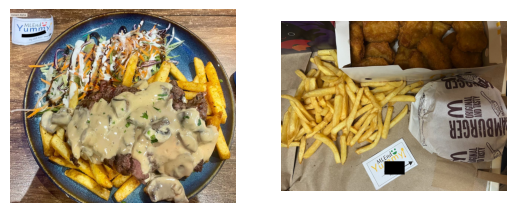

In [8]:
I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/00001.jpg')
plt.subplot(1,2,1)
plt.imshow(I)
plt.axis('off')

I = plt.imread('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/00002.jpg')
plt.subplot(1,2,2)
plt.imshow(I)
plt.axis('off')

# Machine Learning pipeline

The machine learning pipeline we are going to use are data preprocessing and preparation script for a machine learning task, specifically for classifying images of dishes into two categories: 'rice' and 'chips

In [9]:
TrainSet, TestSet, Map = yummy_small_load(datadir_main=baseDir,train_test_split='Benchmark_A')

Total 99 found in /content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images_small/


In [10]:
TrainSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

In [11]:
TestSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

In [12]:
Map

{'Rice_Chips': {'chips': 0, 'rice': 1}}

In [13]:
TrainSet['Y']

array(['chips', 'chips', 'rice', 'rice', 'rice', 'chips', 'rice', 'chips',
       'rice', 'chips', 'chips', 'rice', 'chips', 'rice', 'rice', 'chips',
       'rice', 'rice', 'chips', 'rice', 'chips', 'rice', 'rice', 'chips',
       'chips', 'chips', 'rice', 'rice', 'chips', 'rice', 'rice', 'rice',
       'rice', 'rice', 'chips', 'chips', 'chips', 'rice', 'chips', 'rice',
       'rice', 'chips', 'chips', 'rice', 'chips', 'chips', 'chips',
       'chips', 'chips', 'chips', 'chips', 'rice', 'chips', 'rice',
       'chips', 'chips', 'rice', 'rice', 'chips', 'chips', 'rice', 'rice',
       'rice', 'rice', 'rice', 'chips', 'rice', 'chips', 'rice', 'chips'],
      dtype=object)

In [14]:
TrainSet['Y_encoded']

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0])

In [15]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Y_encoded']
Y_test  = TestSet['Y_encoded']

**Step_5: Visualising Dishes**

Here we will print 5 pictures and 5 pictures of chips randomly by importing OS and creating a directory path.

By using the Try and Except functions we can make sure that if a file path is wrong then the function will return an error instead of breaking down.

Rice


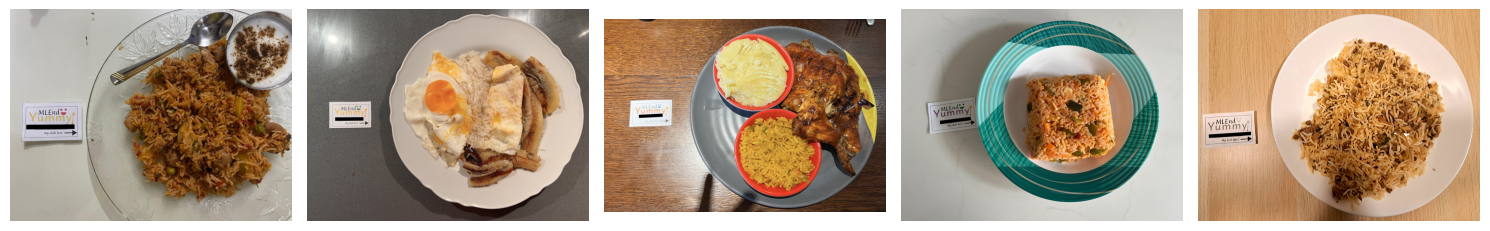

Chips


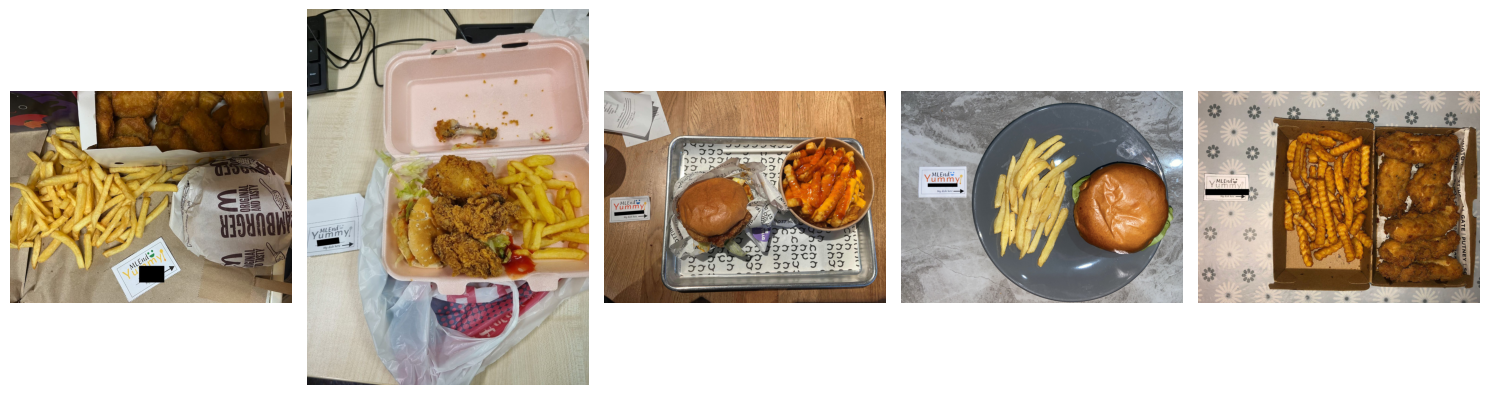

In [16]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

**Step_6: Resizing Images**

To keep the aspect ratio of image as it is, we will append black color to make so that images are squared and then we will resize them to 200*200 pixels.

In [17]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

def preprocess_image(image_path):
    # Read and visualize the provided image
    I = plt.imread(image_path)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

    # Preprocess and resize the image
    I = make_it_square(I, pad=0)
    I = resize_img(I, size=[200, 200])

    # Extract features from the image
    f1 = get_yellow_component(I)
    f2, f3 = GMLC_features(I)
    features = np.array([f1, f2, f3])

    # Normalize the features
    features_normalized = (features - MEAN) / SD

    return features_normalized

In [18]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|70\70|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|29\29|
Done!


((70, 200, 200, 3), (29, 200, 200, 3))

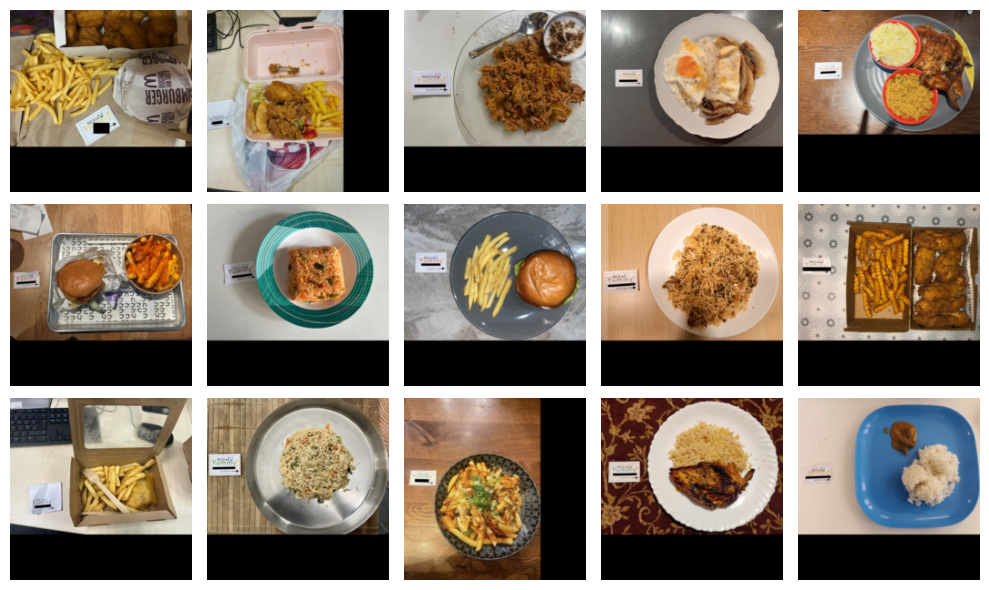

In [19]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

As you can now see that all the images are of the same size.

# Transformation stage

We will use feature extraction as our transformation stage.

**Step_8: Feature Extraction**

Now we will use dimension reducibility to predict the image, whether it contains chips or rice. Stated differently, we will transfer our samples from a space with more dimensions to one with fewer dimensions. One popular method we use to lower the dimensionality of our prediction space is feature extraction. The two functions **get_yellow_component** and **GMLC_features**, which extract three image features to define a new predictor space, are defined in the code cell below:

In [20]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

Let us now extract the three features from each image and create the transform sets X_train_f and X_test_f:

In [21]:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

After formatting both X_train_f and X_test_f as numpy arrays, we can check their respective shapes:

In [22]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((70, 3), (29, 3))

Note that X_train_f represents a collection of 183 samples described by 3 attributes and X_test_f represent a collection of 96 samples described by 3 attributes. This feature extraction stage has reduced the dimensionality of our problem from higher to 3D.

**Step_9: Normalisation**

In addition to reducing the dimensionality of the prediction space, let's implement a normalisation stage to ensure that the 3 attributes in the new prediction space take on a similar range of values. We will implement standardisation.

**Phase Ten: Linearization**

Let's lastly train and evaluate a linear model that determines whether an image represents a dish with rice or chips based on its three normalized attributes.


In [23]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

# Modelling

We used Naive Bayes, Logistic regression, KNN, Decision tree classifier, SVC, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier as our models. And here I have choosen the best best model as Random Forest Classifier as it has highest accuracy.

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Additional Machine Learning Models

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_fn, Y_train)
nb_ysp = nb_model.predict(X_test_fn)
nb_test_accuracy = accuracy_score(Y_test, nb_ysp)
print('Naive Bayes Test Accuracy:\t', nb_test_accuracy)

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_fn, Y_train)
lr_ysp = lr_model.predict(X_test_fn)
lr_test_accuracy = accuracy_score(Y_test, lr_ysp)
print('Logistic Regression Test Accuracy:\t', lr_test_accuracy)

# k-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_fn, Y_train)
knn_ysp = knn_model.predict(X_test_fn)
knn_test_accuracy = accuracy_score(Y_test, knn_ysp)
print('KNN Test Accuracy:\t', knn_test_accuracy)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_fn, Y_train)
dt_ysp = dt_model.predict(X_test_fn)
dt_test_accuracy = accuracy_score(Y_test, dt_ysp)
print('Decision Tree Test Accuracy:\t', dt_test_accuracy)

# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train_fn, Y_train)
svm_ysp = svm_model.predict(X_test_fn)
svm_test_accuracy = accuracy_score(Y_test, svm_ysp)
print('SVM Test Accuracy:\t', svm_test_accuracy)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_fn, Y_train)
rf_ysp = rf_model.predict(X_test_fn)
rf_test_accuracy = accuracy_score(Y_test, rf_ysp)
print('Random Forest Test Accuracy:\t', rf_test_accuracy)

# Bagging (Random Forest)
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_model.fit(X_train_fn, Y_train)
bagging_ysp = bagging_model.predict(X_test_fn)
bagging_test_accuracy = accuracy_score(Y_test, bagging_ysp)
print('Bagging Test Accuracy:\t', bagging_test_accuracy)

# Boosting (AdaBoost)
boosting_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
boosting_model.fit(X_train_fn, Y_train)
boosting_ysp = boosting_model.predict(X_test_fn)
boosting_test_accuracy = accuracy_score(Y_test, boosting_ysp)
print('Boosting Test Accuracy:\t', boosting_test_accuracy)

Naive Bayes Test Accuracy:	 0.5172413793103449
Logistic Regression Test Accuracy:	 0.5862068965517241
KNN Test Accuracy:	 0.5517241379310345
Decision Tree Test Accuracy:	 0.5862068965517241
SVM Test Accuracy:	 0.4482758620689655
Random Forest Test Accuracy:	 0.6206896551724138
Bagging Test Accuracy:	 0.5862068965517241
Boosting Test Accuracy:	 0.6206896551724138


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


# Methodology

**Training and Validation Steps:**

Training and validating machine learning models involves several steps, including data splitting, model training, and performance assessment. In the context of the provided machine learning pipeline for classifying food items.

**Model Performance Assessment:**

1. Accuracy

# Dataset

We used the MLend_yummy_dataset to create and validate our model.

# Result


Naive Bayes Test Accuracy:	 0.5172413793103449

Logistic Regression Test Accuracy:	 0.5862068965517241

KNN Test Accuracy:	 0.5517241379310345

Decision Tree Test Accuracy:	 0.5862068965517241

SVM Test Accuracy:	 0.4482758620689655

Random Forest Test Accuracy:	 0.6206896551724138

Bagging Test Accuracy:	 0.5862068965517241

Boosting Test Accuracy : 0.6206896551724138

**Testing**

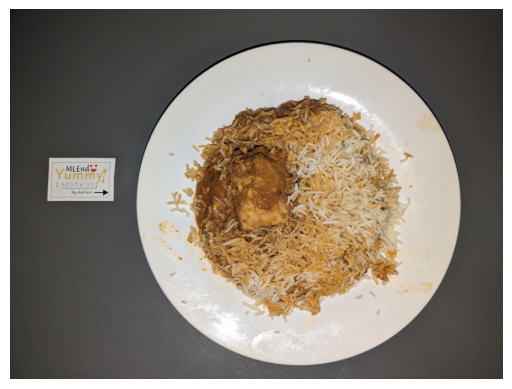

Image: /content/230356331_1.jpg
Linear SVM Prediction: Chips
Naive Bayes Prediction: Chips
Logistic Regression Prediction: Rice
KNN Prediction: Chips
Decision Tree Prediction: Chips
Bagging Prediction: Chips
Boosting Prediction: Rice




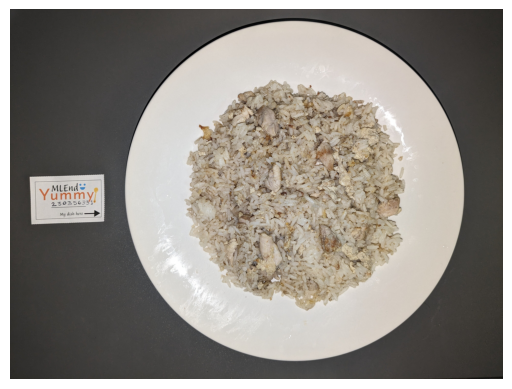

Image: /content/230356331_15.jpg
Linear SVM Prediction: Chips
Naive Bayes Prediction: Rice
Logistic Regression Prediction: Rice
KNN Prediction: Chips
Decision Tree Prediction: Chips
Bagging Prediction: Chips
Boosting Prediction: Chips




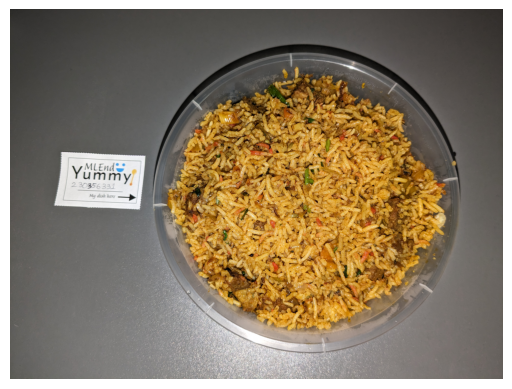

Image: /content/230356331_3.jpg
Linear SVM Prediction: Chips
Naive Bayes Prediction: Rice
Logistic Regression Prediction: Rice
KNN Prediction: Rice
Decision Tree Prediction: Rice
Bagging Prediction: Chips
Boosting Prediction: Rice




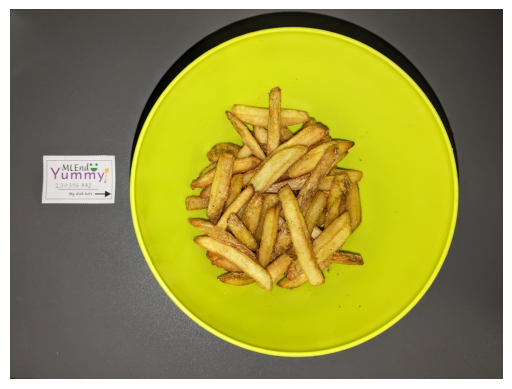

Image: /content/230356331_7.jpg
Linear SVM Prediction: Rice
Naive Bayes Prediction: Chips
Logistic Regression Prediction: Rice
KNN Prediction: Rice
Decision Tree Prediction: Chips
Bagging Prediction: Rice
Boosting Prediction: Rice




In [25]:
# Replace 'your_image_path.jpg' with the path to the new images you want to classify
image_paths_to_test = [
    '/content/230356331_1.jpg', '/content/230356331_15.jpg', '/content/230356331_3.jpg',
    '/content/230356331_7.jpg'
    # Add paths for the remaining images
]

# Preprocess and classify each test image using the trained models
for image_path in image_paths_to_test:
    # Preprocess the image
    preprocessed_features = preprocess_image(image_path)

    # Classify using Linear SVM model
    svm_prediction = svm_model.predict([preprocessed_features])[0]

    # Classify using Naive Bayes model
    nb_prediction = nb_model.predict([preprocessed_features])[0]

    # Classify using Logistic Regression model
    lr_prediction = lr_model.predict([preprocessed_features])[0]

    # Classify using k-Nearest Neighbors (KNN) model
    knn_prediction = knn_model.predict([preprocessed_features])[0]

    # Classify using Decision Tree model
    dt_prediction = dt_model.predict([preprocessed_features])[0]

    # Classify using Bagging (Random Forest) model
    bagging_prediction = bagging_model.predict([preprocessed_features])[0]

    # Classify using Boosting (AdaBoost) model
    boosting_prediction = boosting_model.predict([preprocessed_features])[0]

    # Print predictions
    print(f"Image: {image_path}")
    print(f"Linear SVM Prediction: {'Rice' if svm_prediction == 1 else 'Chips'}")
    print(f"Naive Bayes Prediction: {'Rice' if nb_prediction == 1 else 'Chips'}")
    print(f"Logistic Regression Prediction: {'Rice' if lr_prediction == 1 else 'Chips'}")
    print(f"KNN Prediction: {'Rice' if knn_prediction == 1 else 'Chips'}")
    print(f"Decision Tree Prediction: {'Rice' if dt_prediction == 1 else 'Chips'}")
    print(f"Bagging Prediction: {'Rice' if bagging_prediction == 1 else 'Chips'}")
    print(f"Boosting Prediction: {'Rice' if boosting_prediction == 1 else 'Chips'}")
    print("\n" + "="*50 + "\n")

# 9 Conclusions

Now I have tried 8 models, from which **Random Forest and Boosting gives the best test accuracy**. I have tested few imgaes on the trained models, and it predicted quite well.